In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from celmech.maps import EncounterMap

In [2]:
from sympy import bell
def bell_poly_sum(n,farr,garr):
    """
    Evaluate the :math:`n`th derivative of :math:`f(g(x))`
    where 
     f(u) = f[0] + f[1]*u + f[2]*u^2/2 + ... + f[n]*u^n/n! + ...
     g(x) = g[0] + g[1]*x + g[2]*x^2/2 + ... + g[n]*x^n/n! + ...
    """
    #
    return np.sum([farr[k] * bell(n,k,garr[1:n-k+2]) for k in range(1,n)])

from scipy.special import binom
def to_uv_derivs(T,n,m,c,s):
    tot = np.zeros(2)
    R = np.array([[c,s],[-s,c]])
    for l in range(n+1):
        binom_nl = binom(n,l)
        for l1 in range(m+1):
            cfactor = c**(m+l-l1)
            sfactor = s**(n-l+l1)
            coeff = (-1)**l1 * binom_nl * binom(m,l1) * cfactor * sfactor
            tot +=  coeff * T[:,l+l1,n+m-l-l1]
    return R @ tot

def rotate_derivs_array(T,theta_rot):
    c,s = np.cos(theta_rot),np.sin(theta_rot)
    T1 = np.zeros(T.shape)
    for n in range(1,T.shape[1]):
        for l in range(n+1):
            T1[:,l,n-l] = to_uv_derivs(T,l,n-l,c,s)
    return T1

### Utilities for calculating Psis ####
from collections import defaultdict
def deriv_of_coeff_and_pows(coeff,pows):
    new_pows = np.append(pows,0)
    results = []
    for m in range(len(pows)):
        if new_pows[m]>0:
            new_pows = np.append(pows,0)
            new_pows[m]-=1
            new_pows[m+1]+=1
            results.append((coeff * pows[m], new_pows))
    return results

def _consolidate_coeff_and_pows_list(cp_list):
    pows_arr = np.array([_[1] for _ in cp_list])
    coeff_arr = np.array([_[0] for _ in cp_list])
    i = 0
    tot = 0
    result = []
    while tot < len(coeff_arr):
        pows = pows_arr[i]
        msk = np.alltrue(pows_arr==pows,axis=1)
        coeff = np.sum(coeff_arr[msk])
        result+=[(coeff,pows)]
        # next index of unique powers
        tot += np.sum(msk)
        i=i+np.argmin(msk[i:])
    return result


def get_Psi_dicts(n):
    PsiOld = {
        (0,1):[(1,np.array([0,1]))],
        (1,0):[(1,np.array([0,0]))]
    }
    Psis = [0,PsiOld]
    for m in range(1,n):
        PsiNew = defaultdict(list)
        for ij,coeffs_and_pows in PsiOld.items():
            i,j = ij
            PsiNew[(i+1,j)] += coeffs_and_pows
            for coeff,pows in coeffs_and_pows:
                PsiNew[(i,j)] += deriv_of_coeff_and_pows(coeff,pows)
                add_one = pows.copy()
                add_one[1] +=1
                PsiNew[(i,j+1)] += [(coeff,add_one)]
        PsiOld = PsiNew.copy()
        for ij, lst in PsiOld.items():
            PsiOld[ij] = _consolidate_coeff_and_pows_list(lst)
        Psis.append(PsiOld)
    return Psis

def evaluate_Psi(Psi_dict,Tprimes_arr,farr):
    tot = 0
    for ij,coeffs_and_pows_list in Psi_dict.items():
        i,j = ij 
        Tprime_ij = Tprimes_arr[i,j]
        sub_tot = 0
        for coeff,pows in coeffs_and_pows_list:
            if coeff==0:
                continue
            npows = pows.shape[0]
            sub_tot += coeff * np.product(farr[:npows]**pows)
        tot+= Tprime_ij * sub_tot
    return tot

def func_from_series(coeffs,x):
    """
    Given a set of Taylor series coefficients, (c_0,....,c_N), evalute
    the sum
    
    .. math::
        \sum_{n=0}^{N} c_n x^n / n!
    """
    return coeffs @ np.array([x**n/np.math.factorial(n) for n in range(coeffs.shape[0])])

def manifold_approx(u,n,farr,garr):
    f = lambda x: func_from_series(farr[:n+1],x)
    g = lambda x: func_from_series(garr[:n+1],x)
    
    p0 = np.array([u,f(u)])
    p1 = np.array([g(u),f(g(u))])
    
    return p0,p1

In [3]:
emap = EncounterMap(6e-5,4,0.5,Nmax=5,mod=False)

In [4]:
Nmax = 11
xunst = np.array((np.pi,0))
T = emap.partial_derivs(xunst,Nmax)

In [5]:
jac = np.array([[T[0][1,0],T[0][0,1]],[T[1][1,0],T[1][0,1]]])
vals,vecs = np.linalg.eig(jac)

# Unstable eigenvalue and direction
lambdaU = vals[0]
uvec = vecs[:,0]
theta_rot = np.arctan2(uvec[1],uvec[0])

s,c = np.sin(theta_rot),np.cos(theta_rot)
R = np.array([[c,s],[-s,c]])

# Fill list of Psis
Psis = get_Psi_dicts(Nmax)

# Get rotated derivatives array
Tprime = rotate_derivs_array(T,theta_rot)

In [6]:
TU_01 = Tprime[0][0,1]
Tperp_01 = Tprime[1][0,1]
farr,garr = np.zeros((2,Nmax + 1))
garr[1] = lambdaU
[Psi.pop((0,1),None) for Psi in Psis[1:]] # Remove (0,1) entry from Psis
for n in range(2,Nmax + 1):
    Psi_dict=Psis[n]
    
    # Get numerical value of Psis
    PsiPerp = evaluate_Psi(Psi_dict,Tprime[1],farr)
    PsiU = evaluate_Psi(Psi_dict,Tprime[0],farr)


    denom = Tperp_01-lambdaU**n
    Bsum = bell_poly_sum(n,farr,garr)
    farr[n] = (Bsum-PsiPerp)/denom
    garr[n] = TU_01 * farr[n] + PsiU
    #print(n,farr[n],garr[n])

(1e-16, 8.701875338331115)

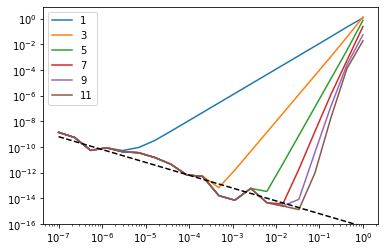

In [7]:
for nmax in [1,3,5,7,9,11]:
    u0s = np.logspace(-7,0,20)
    errors = []
    for u0 in u0s:
        p0,p1_approx=manifold_approx(u0,nmax,farr,garr)
        p1 = R @ (emap(xunst + R.T @ p0 ) - xunst)
        errors.append(np.linalg.norm((p1-p1_approx))/np.linalg.norm(p1))
    plt.plot(u0s,errors,label=nmax)
plt.plot(u0s,np.abs((emap(xunst)-xunst)[1]/u0s),'k--')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymin=1e-16)

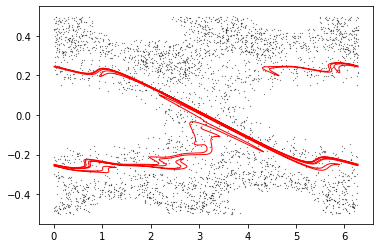

In [11]:
emap.mod_p = False
emap.mod_theta = False

nmax=11
u0=2e-2
p0,p1_approx=manifold_approx(u0,nmax,farr,garr)
Tprime = lambda p: R @ (emap(xunst + (R.T @ p)) - xunst)
p1 = Tprime(p0)
#p1 = R @ emap(R.T @ p0)
(np.linalg.norm((p1-p1_approx))/np.linalg.norm(p1))
u1 = func_from_series(garr,u0)


wrap1 = lambda x: np.mod(x+0.5,1)-0.5
wrap2pi = lambda x: np.mod(x,2*np.pi)
uvals = np.linspace(u0,u1,5000)
_,ps = manifold_approx(uvals,nmax,farr,garr)
x = np.array([np.pi,0.01])
xs = []
for i in range(3500):
    xs.append(x)
    x = emap(x)
theta,p=np.array(xs).T
plt.plot(wrap2pi(theta),wrap1(p),'k.',ms=0.4)

_,ps = manifold_approx(uvals,nmax,farr,garr)
thetaU,pU = ps
for n in range(9):
    ps = np.transpose([Tprime(p) for p in ps.T])
    thetaU = np.concatenate((thetaU,ps[0]))
    pU = np.concatenate((pU,ps[1]))

thetaU,pU = R.T @ [thetaU,pU]
thetaU = wrap2pi(xunst[0] + thetaU)
pU = wrap1(xunst[1] + pU)

breaksX = np.abs(thetaU[1:] - thetaU[:-1])>np.pi
breaksY = np.abs(pU[1:] - pU[:-1])>0.5

# thetaU,pU = mymod((R.T @ ps))

breaksX = np.abs(thetaU[1:] - thetaU[:-1])>np.pi
breaksY = np.abs(pU[1:] - pU[:-1])>0.5
break_indices = np.arange(len(thetaU)-1)[np.logical_or(breaksX,breaksY)]


break_indices=np.concatenate(([0],break_indices,[-1]))
for ilow,ihi in zip(break_indices[:-1],break_indices[1:]):
    plt.plot(thetaU[ilow+1:ihi],pU[ilow+1:ihi],'r-',lw=1)
    
